# Step 1: Import Libraries and Set Up Environment

Importing necessary libraries for data manipulation, machine learning, and image processing.

In [1]:
# Step 1: Import Libraries and Set Up Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import warnings

# Suppress warnings and set up visualization styles

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='viridis')


In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


# Step 2: Define Constants and Load Data Paths

This section defines constants for file paths and labels for the diagnosis categories. It also loads a sample of the training and testing datasets.

In [4]:
# Define Constants and Load Data Paths
DATA_FOLDER = r"../dataset"  # Replace with your data folder path
TRAIN_FILE = "train-00000-of-00001-c08a401c53fe5312.parquet"
TEST_FILE = "test-00000-of-00001-44110b9df98c5585.parquet"

DIAGNOSIS_LABELS = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented"
}

In [5]:
# Construct file paths for train and test datasets
train_file_path = os.path.join(DATA_FOLDER, TRAIN_FILE).replace("\\", "/")
test_file_path = os.path.join(DATA_FOLDER, TEST_FILE).replace("\\", "/")

In [6]:
# Load the training and testing datasets (use small samples for demonstration)
train_data = pd.read_parquet(train_file_path).head(100)  # Load first 100 rows for training
test_data = pd.read_parquet(test_file_path).head(50)     # Load first 50 rows for testing

print("Training and testing data loaded successfully.")

Training and testing data loaded successfully.


# Step 3: Define Image Decoding Function

This function decodes byte-encoded images into NumPy arrays for further processing.


In [7]:
def decode_image_from_bytes(image_dict):
    """
    Decodes image bytes into a NumPy array.
    """
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)  # Decode as a color image (BGR format)
        return img
    return None

print("Image decoding function defined.")

Image decoding function defined.


# Step 4: Apply Decoding to Train and Test DataFrames

This section applies the decoding function to both the training and testing datasets.

In [8]:
train_data['decoded_scan'] = train_data['image'].apply(decode_image_from_bytes)
test_data['decoded_scan'] = test_data['image'].apply(decode_image_from_bytes)

print("Images decoded successfully.")

Images decoded successfully.


# Step 5: Display Sample Data and Label Distribution

This part displays sample data from both datasets and plots the distribution of diagnoses in the training set.

In [9]:
train_data.head()



,image,label,decoded_scan
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [10]:
test_data.head()

,image,label,decoded_scan
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


### 5.1  Plot label distribution in the training dataset

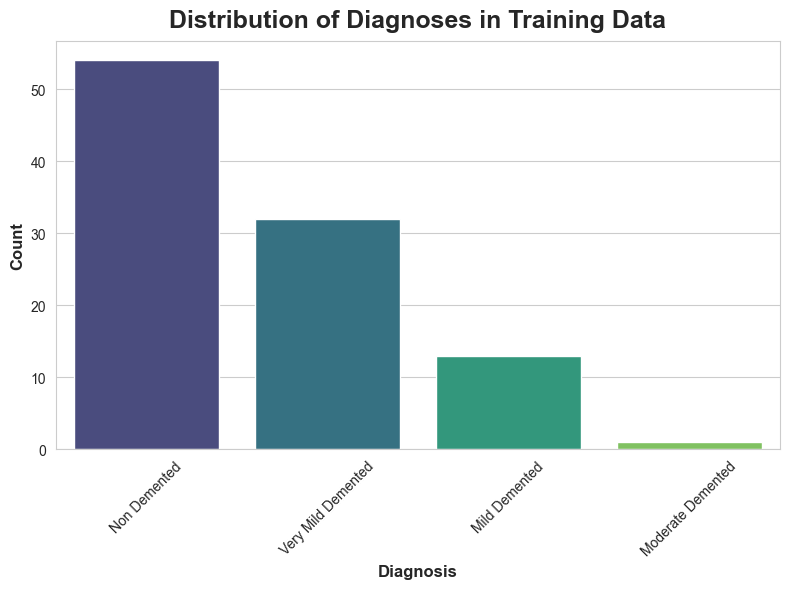

In [11]:
label_distribution = train_data['label'].map(DIAGNOSIS_LABELS ).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")
plt.title("Distribution of Diagnoses in Training Data")
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.xticks(rotation=45)
plt.show()


# Step 6: Preprocess Images for Model Input (Resizing and Normalization)

In this section, images are resized to a uniform size of (128 \times 128) pixels and normalized to have pixel values between (0) and (1).


In [12]:

def preprocess_images(image_array):
    """
    Resize images to (128x128) and normalize pixel values.
    """
    resized_images = []
    for img in image_array:
        if img is not None:
            resized_img = cv2.resize(img, (128, 128)) / 255.0  # Normalize pixel values to [0,1]
            resized_images.append(resized_img)
        else:
            resized_images.append(np.zeros((128, 128, 3)))  # Placeholder for missing images
    return np.array(resized_images)

X_train_images = preprocess_images(train_data['decoded_scan'])
X_test_images = preprocess_images(test_data['decoded_scan'])

y_train_labels = train_data['label'].values
y_test_labels = test_data['label'].values

print(f"Training images shape: {X_train_images.shape}")
print(f"Testing images shape: {X_test_images.shape}")

Training images shape: (100, 128, 128, 3)
Testing images shape: (50, 128, 128, 3)


# Step 7: Split Training Data into Train/Validation Sets

The training data is split into training and validation sets to evaluate model performance during training.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train_labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 80
Validation set size: 20


# Step 8: Build the CNN Model for Classification

This section defines a CNN architecture with convolutional layers followed by max pooling layers. The model is compiled with an optimizer and loss function suitable for multi-class classification.

In [14]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(DIAGNOSIS_LABELS), activation='softmax')  # Output layer with softmax activation
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,116 (14.14 MB)

 Trainable params: 3,706,116 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

# Step 9: Train the Model on Training Data

The model is trained on the training dataset while validating on the validation dataset over a specified number of epochs.

In [15]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    verbose=1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.3269 - loss: 1.7711 - val_accuracy: 0.3000 - val_loss: 1.0815
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3839 - loss: 1.0645 - val_accuracy: 0.5500 - val_loss: 1.1153
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5585 - loss: 1.0453 - val_accuracy: 0.5500 - val_loss: 1.0272
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5264 - loss: 1.0198 - val_accuracy: 0.5500 - val_loss: 1.0101
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5347 - loss: 0.9456 - val_accuracy: 0.5500 - val_loss: 1.0121
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.5750 - loss: 0.8839 - val_accuracy: 0.5500 - val_loss: 1.0351
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5686 - loss: 0.9228 - val_accuracy: 0.5500 - val_loss: 1.0407
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6321 - loss: 0.8102 - val_accuracy: 0.5500 - val_loss:

# Step 10: Evaluate the Model on Test Data

The trained model is evaluated on the test dataset to determine its accuracy.

In [16]:
test_loss, test_accuracy = model.evaluate(X_test_images, y_test_labels)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4421 - loss: 1.0946

Test Accuracy: 0.4600


# Step 11: Visualize Training History (Loss and Accuracy)

Finally, this section visualizes the training history by plotting loss and accuracy metrics over epochs for both training and validation datasets.

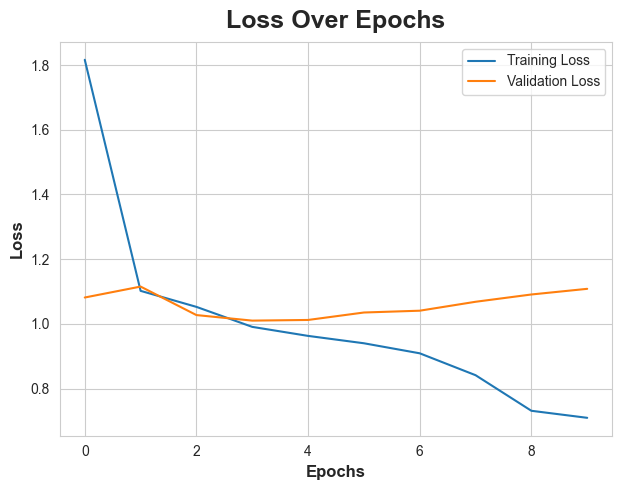

In [17]:
plt.figure(figsize=(12, 5))

# Plot training/validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


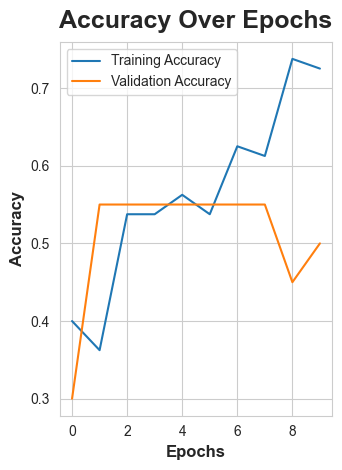

In [18]:
# Plot training/validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()